In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from imblearn.under_sampling import NearMiss

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Classifier/Regressor
import xgboost as xgb

# Optimization
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization

# import the dataset

https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [3]:
df = pd.read_csv('Hotel Reservations.csv')
df.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

# Exploratory Data Analysis

In [4]:
df.shape

(36275, 19)

In [5]:
df.isna().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

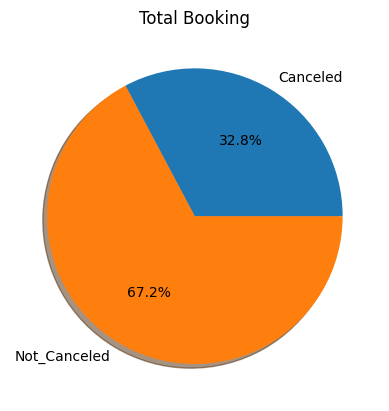

In [6]:
booking_status_count = df.groupby('booking_status').count().reset_index()

def func(pct):
    return "{:1.1f}%".format(pct)
 
plt.pie(booking_status_count.Booking_ID.values, labels=booking_status_count.booking_status.values, autopct=lambda pct: func(pct), shadow=True)
plt.title('Total Booking')
plt.show()

<Axes: xlabel='booking_status', ylabel='avg_price_per_room'>

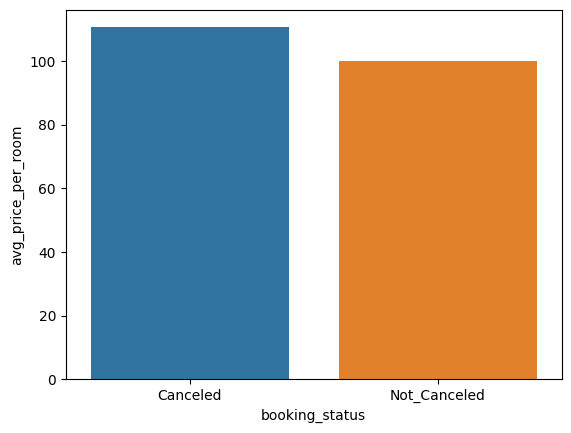

In [7]:
average_price_status = df.groupby('booking_status')['avg_price_per_room'].mean().reset_index()
sns.barplot(data=average_price_status, x="booking_status", y="avg_price_per_room")

In [8]:
average_price_status

booking_status  avg_price_per_room
0       Canceled          110.589966
1   Not_Canceled           99.931412

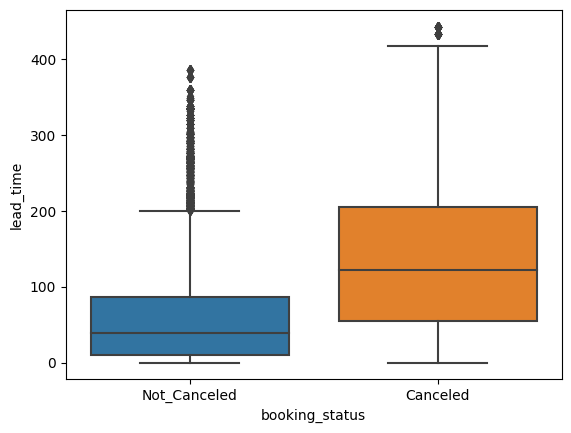

In [9]:
g = sns.boxplot(df, x='booking_status', y="lead_time")

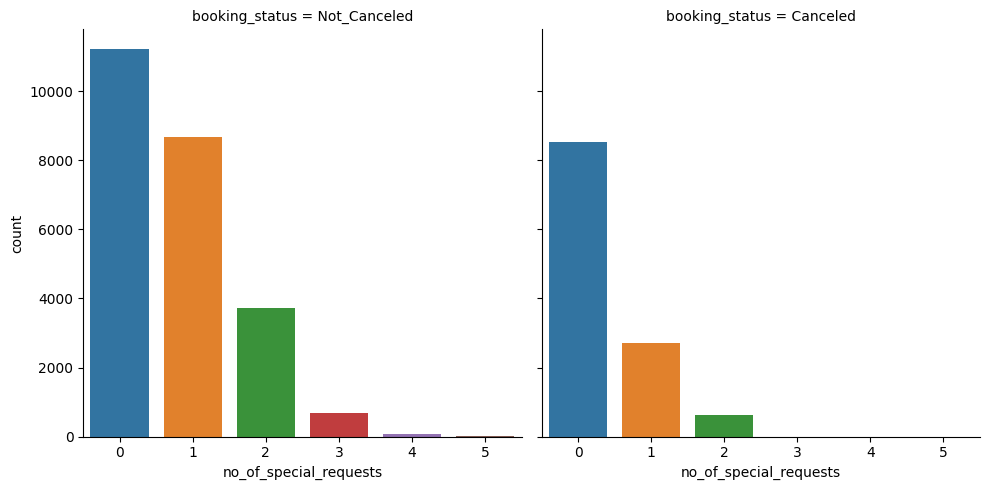

In [10]:
g = sns.catplot(df, x="no_of_special_requests", col='booking_status', kind='count')

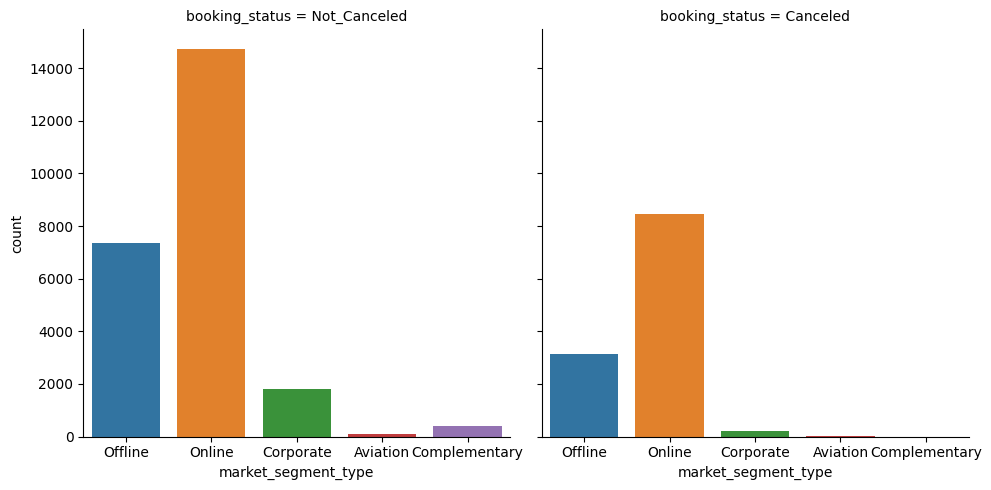

In [11]:
g = sns.catplot(df, x="market_segment_type", col='booking_status', kind='count')

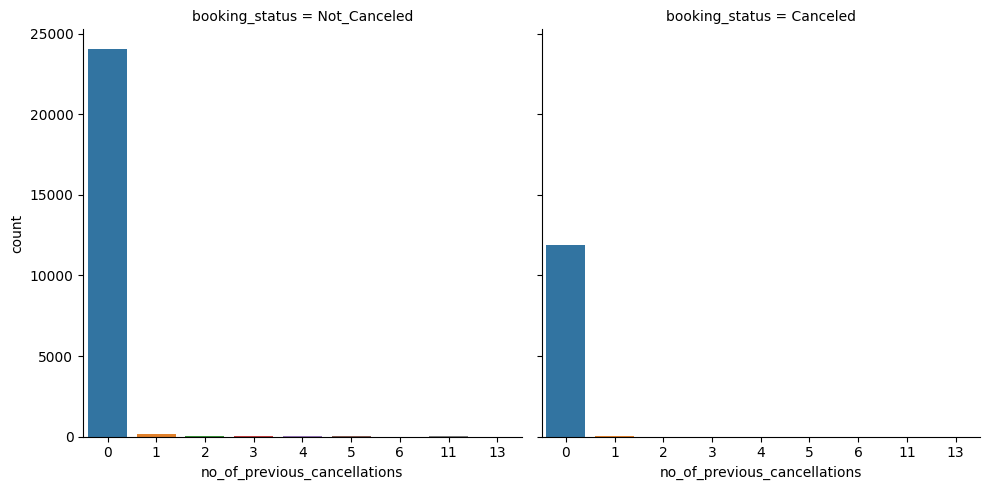

In [12]:
g = sns.catplot(df, x="no_of_previous_cancellations", col='booking_status', kind='count')

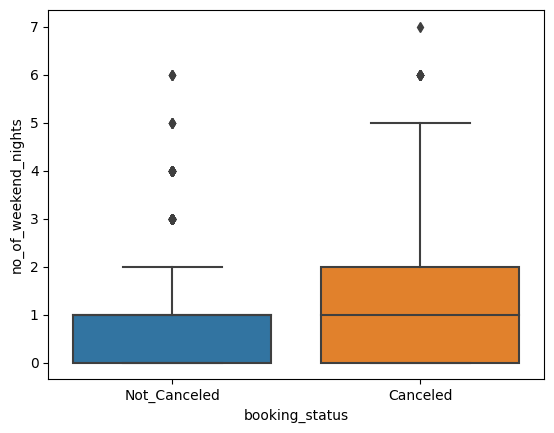

In [13]:
g = sns.boxplot(df, y="no_of_weekend_nights", x='booking_status')

In [14]:
arr = [1,2,3]
lambda arr: [list(map(lambda x:x**2, filter(lambda y:y>0,row))) for row in arr]
arr = int("".join(str(i) for i in arr))
arr

123

In [15]:

df[['no_of_adults','no_of_children']].head(1)

no_of_adults  no_of_children
0             2               0

In [16]:
df['Booking_ID'].duplicated().sum()

0

So far,
1. There is no missing/duplicate values in this dataset (36275 rows and 19 columns) to be dealt with.
2. Can't tell if any columns are statistically correlated at a glance. We have to dig into it by using data visulization.

## Convert categorical variable to numerical 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [18]:
df['market_segment_type'].unique()

array(['Offline', 'Online', 'Corporate', 'Aviation', 'Complementary'],
      dtype=object)

In [19]:
# change the 'market_segment_type' to integer
segment = {'Offline':1, 'Online':2, 'Corporate':3, 'Aviation':4, 'Complementary':5}
df['market_segment_type'] = df['market_segment_type'].apply(lambda x: segment[x])
df.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

   market_segment_type  repeated_guest  no_of_previous_cancellations  \
0                    1               0                             0   
1                    2               0                             0   
2                    2               0                             0   
3                    2               0                             0   
4                    2               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

In [20]:
df['room_type_reserved'].unique()

array(['Room_Type 1', 'Room_Type 4', 'Room_Type 2', 'Room_Type 6',
       'Room_Type 5', 'Room_Type 7', 'Room_Type 3'], dtype=object)

In [21]:
df['type_of_meal_plan'].unique()

array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2', 'Meal Plan 3'],
      dtype=object)

In [22]:
# change the 'booking_status' from string type to integer type (binary value)
df['booking_status'] = df['booking_status'].replace({'Canceled': 1, 'Not_Canceled': 0})
# change the 'type_of_meal_plan' from string type to integer type (binary value)
df['type_of_meal_plan'] = df['type_of_meal_plan'].replace({'Meal Plan 1': 1, 'Meal Plan 2': 2, 'Meal Plan 3':3, 'Not Selected':0})
# change the 'room_type_reserved' from string type to integer type (binary value)
df['room_type_reserved'] = df['room_type_reserved'].replace({'Room_Type 1':1, 'Room_Type 4':4, 'Room_Type 2':2, 'Room_Type 6':6,
       'Room_Type 5':5, 'Room_Type 7':7, 'Room_Type 3':3 })
df.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights  type_of_meal_plan  required_car_parking_space  \
0                  2                  1                           0   
1                  3                  0                           0   
2                  1                  1                           0   
3                  2                  1                           0   
4                  1                  0                           0   

   room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0                   1        224          2017             10             2   
1                   1          5          2018             11             6   
2                   1          1          2018              2            28   
3                   1        211          2018              5            20   
4                   1         48          2018              4            11   

   market_segment_type  repeated_guest  no_of_previous_cancellations  \
0                    1               0                             0   
1                    2               0                             0   
2                    2               0                             0   
3                    2               0                             0   
4                    2               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests  booking_status  
0                       0               0  
1                       1               0  
2                       0               1  
3                       0               1  
4                       0               1

In [23]:
df = df.iloc[:,1:]
df.dtypes

no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                         int64
required_car_parking_space                int64
room_type_reserved                        int64
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                       int64
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                            int64
dtype: object

In [24]:
df.groupby('arrival_year')['no_of_adults'].agg('count')

arrival_year
2017     6514
2018    29761
Name: no_of_adults, dtype: int64

<Axes: >

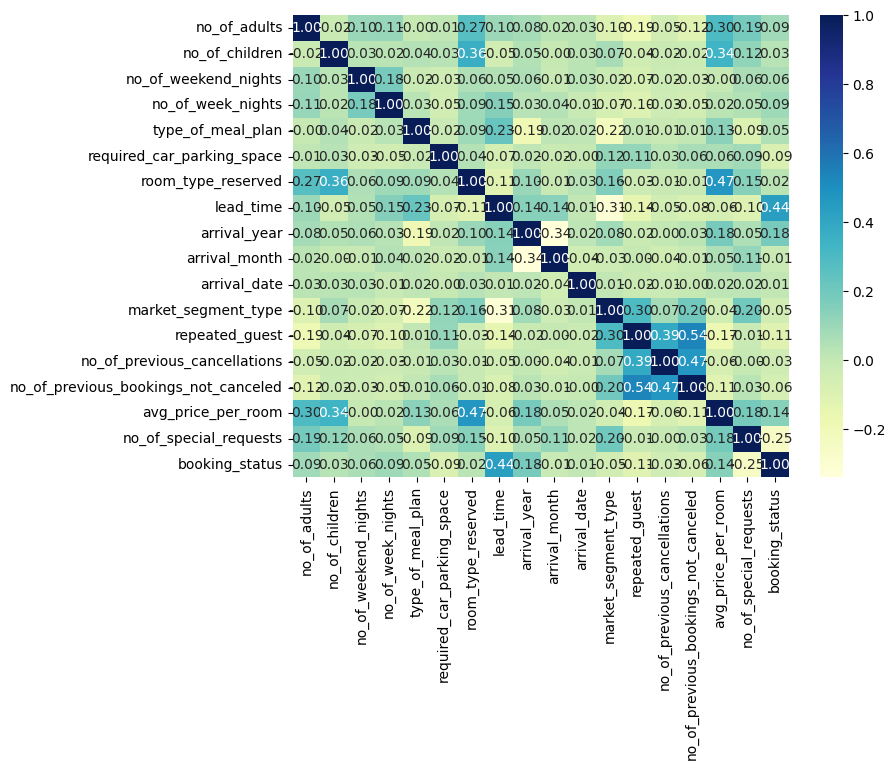

In [25]:
# Correlations
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f')

In [26]:
correlation = df.corr()['booking_status'].abs().sort_values(ascending = False)
correlation

booking_status                          1.000000
lead_time                               0.438538
no_of_special_requests                  0.253070
arrival_year                            0.179529
avg_price_per_room                      0.142569
repeated_guest                          0.107287
no_of_week_nights                       0.092996
no_of_adults                            0.086920
required_car_parking_space              0.086185
no_of_weekend_nights                    0.061563
no_of_previous_bookings_not_canceled    0.060179
type_of_meal_plan                       0.049374
market_segment_type                     0.048733
no_of_previous_cancellations            0.033728
no_of_children                          0.033078
room_type_reserved                      0.022986
arrival_month                           0.011233
arrival_date                            0.010629
Name: booking_status, dtype: float64

We can see that 'lead_time'plays an important role in the cancellation, and 'no_of_special_requests' follows up.

In [27]:
# dropping columns that are not useful nor interesting

useless_col = ['arrival_date', 'no_of_children']

df.drop(useless_col, axis = 1, inplace = True)

<Figure size 1200x1100 with 0 Axes>

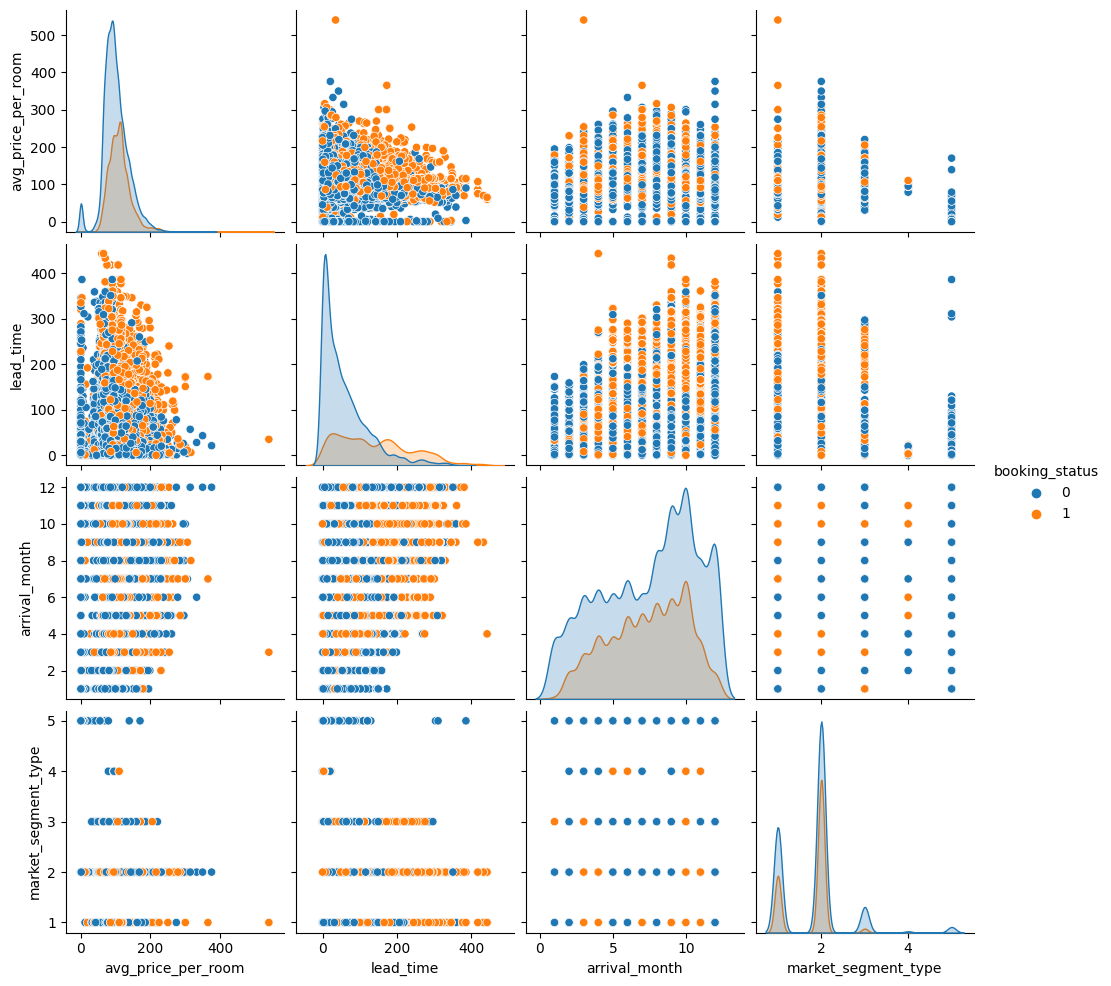

In [28]:
plt.figure(figsize=(12,11))
sns.pairplot(df[['avg_price_per_room', 'lead_time', 'arrival_month', 'market_segment_type', 'booking_status']], hue='booking_status')
# The diagonal line shows the distribution of values in that variable using a histogram. 
# Each other cell shows the relationship as a scatterplot between the two variables at their intersection.

market_segment_type = {'Offline':1, 'Online':2, 'Corporate':3, 'Aviation':4, 'Complementary':5}
1. Online booking tends to be cancelled more often than other segments.
2. Online booking over $300 per room has smaller chance to cancel.

## avg price by month?

In [29]:
ttl_guests = df.groupby(['arrival_month'])['avg_price_per_room'].mean().reset_index()
ttl_guests.columns=['month','avg price per room']
ttl_guests

month  avg price per room
0       1           74.749763
1       2           80.733644
2       3           91.883698
3       4          101.998801
4       5          113.810677
5       6          111.966500
6       7          111.649318
7       8          113.203984
8       9          115.906916
9      10          104.460873
10     11           91.285426
11     12           88.952185

In [30]:
px.line(ttl_guests, x = 'month', y = ['avg price per room'],
        title='Avg price per room per month', template = 'plotly_dark')

<Axes: xlabel='booking_status', ylabel='count'>

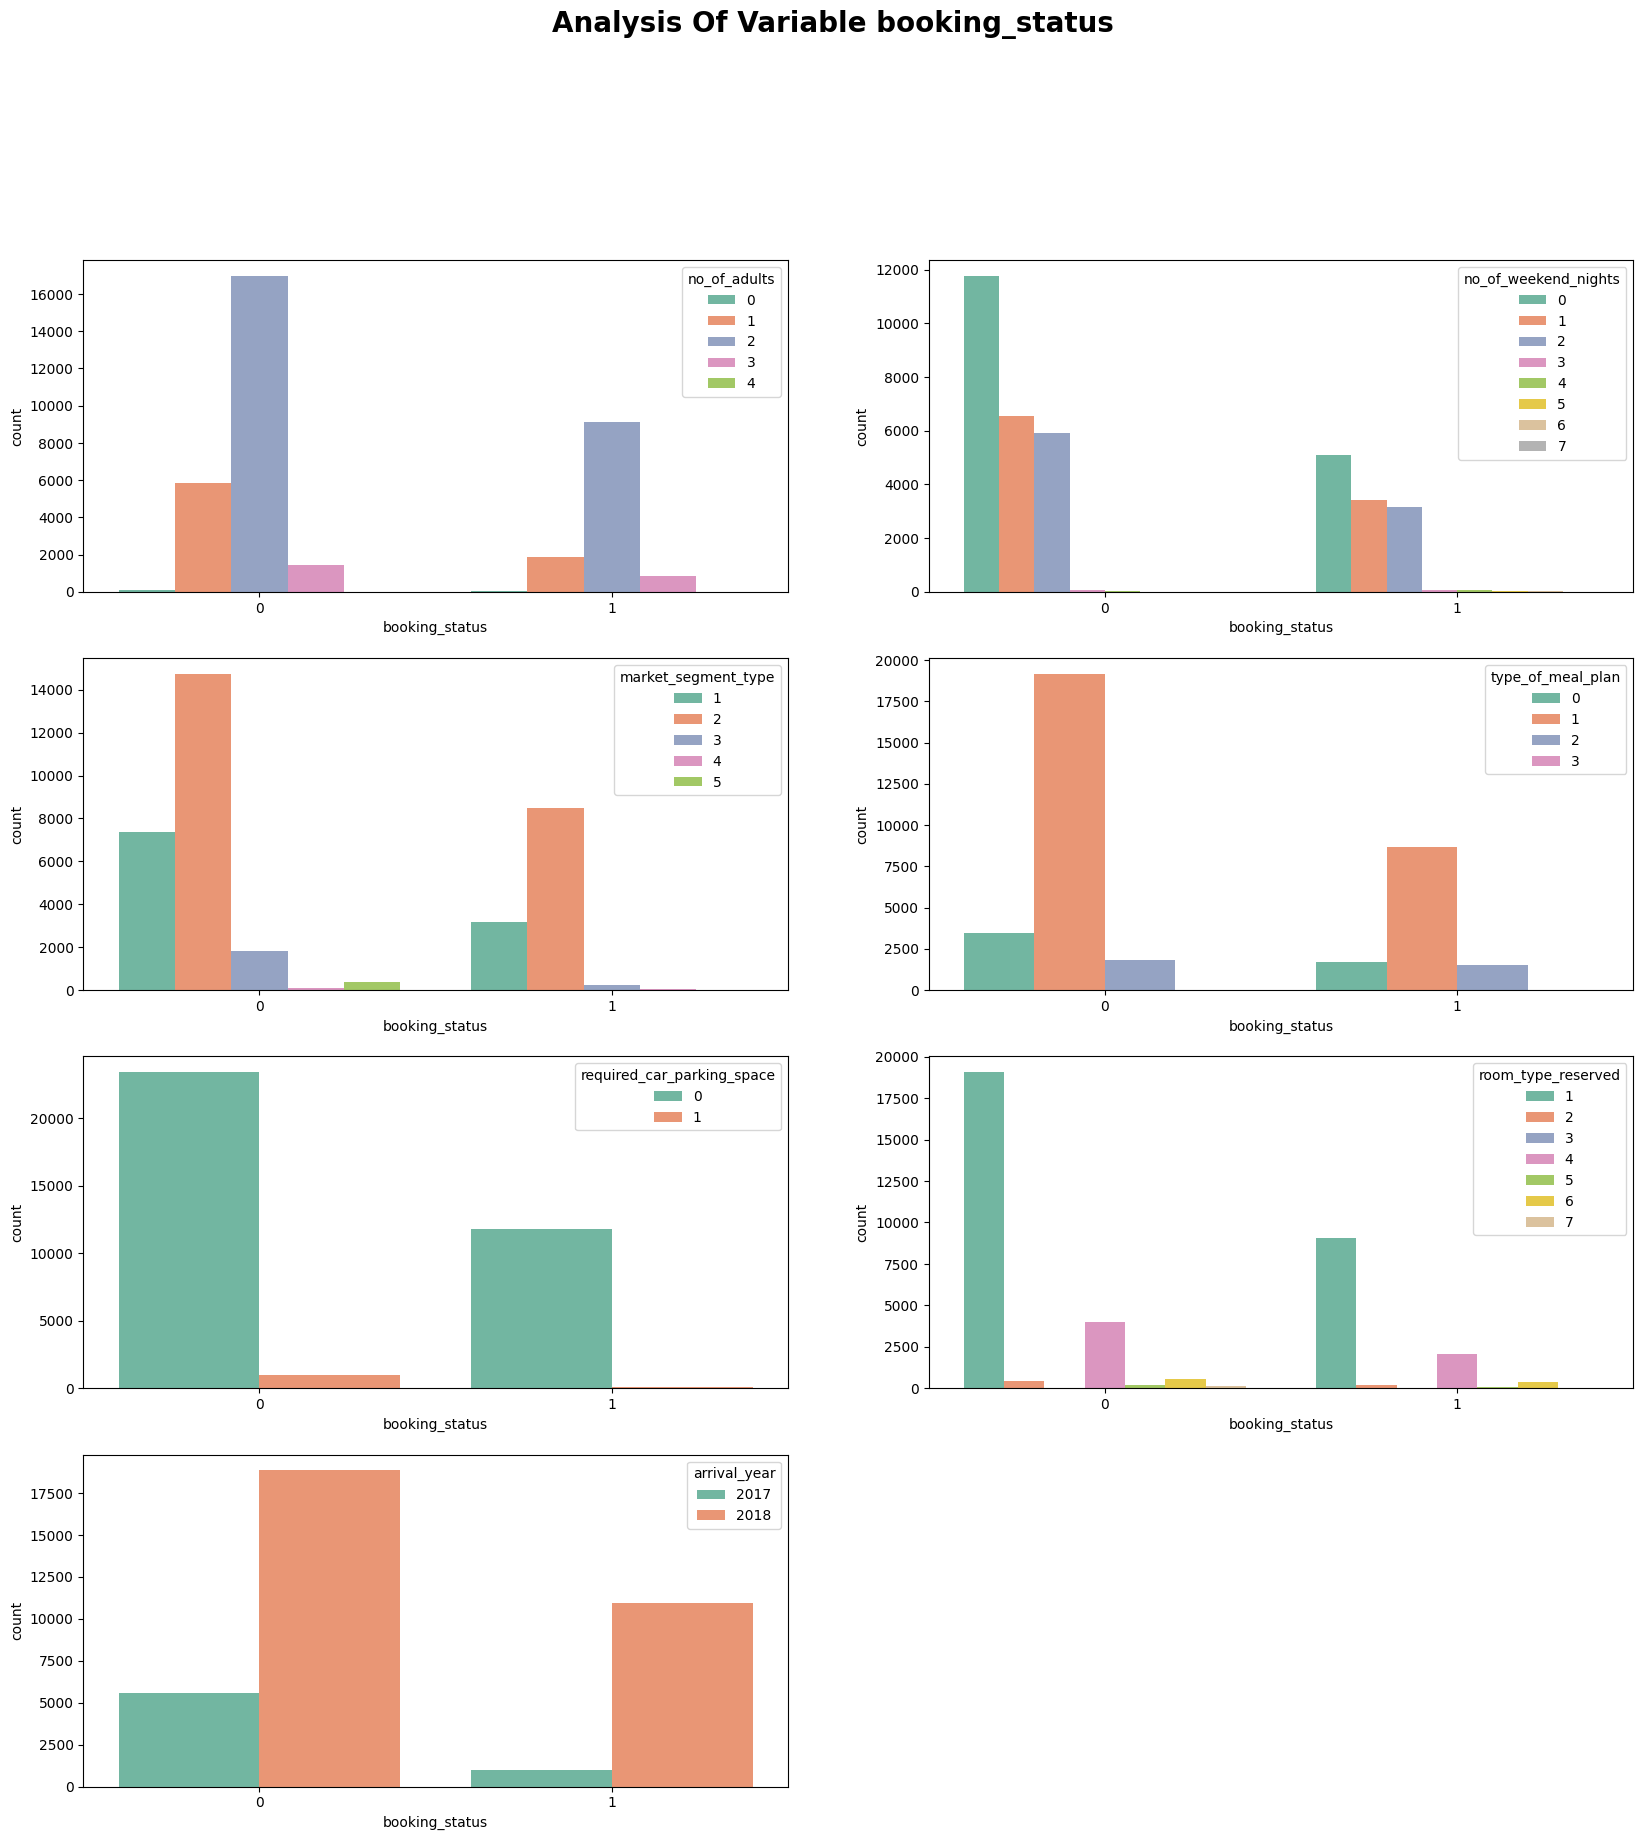

In [31]:
plt.figure(figsize = (20, 25))
plt.suptitle("Analysis Of Variable booking_status",fontweight="bold", fontsize=20)

plt.subplot(5,2,1)
sns.countplot(x = 'booking_status', hue = 'no_of_adults', palette = 'Set2', data = df)

plt.subplot(5,2,2)
sns.countplot(x = 'booking_status', hue = 'no_of_weekend_nights', palette = 'Set2', data = df)

plt.subplot(5,2,3)
sns.countplot(x = 'booking_status', hue = 'market_segment_type', palette = 'Set2', data = df)

plt.subplot(5,2,4)
sns.countplot(x = 'booking_status', hue = 'type_of_meal_plan', palette = 'Set2', data = df)

plt.subplot(5,2,5)
sns.countplot(x = 'booking_status', hue = 'required_car_parking_space', palette = 'Set2', data = df)

plt.subplot(5,2,6)
sns.countplot(x = 'booking_status', hue = 'room_type_reserved', palette = 'Set2', data = df)

plt.subplot(5,2,7)
sns.countplot(x = 'booking_status', hue = 'arrival_year', palette = 'Set2', data = df)

From the above plots, we can see:
1. single traveler has less cancellations
2. The more weekened nights, the more cancellations
3. Although the cancellations in 2017 are much less than in 2018, this is because the dataset is imbalanced. 2018 has 4 more times data than 2017 has.

In [32]:
# count the room_type
P = df.groupby('room_type_reserved')['no_of_adults'].agg('count')
P

room_type_reserved
1    28130
2      692
3        7
4     6057
5      265
6      966
7      158
Name: no_of_adults, dtype: int64

C:\Users\vickytc\AppData\Local\Temp\ipykernel_18260\4187558839.py:11: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vickytc\AppData\Local\Temp\ipykernel_18260\4187558839.py:14: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vickytc\AppData\Local\Temp\ipykernel_18260\4187558839.py:17: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vickytc\AppData\Local\Temp\ipykernel_18260\4187558839.py:20: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




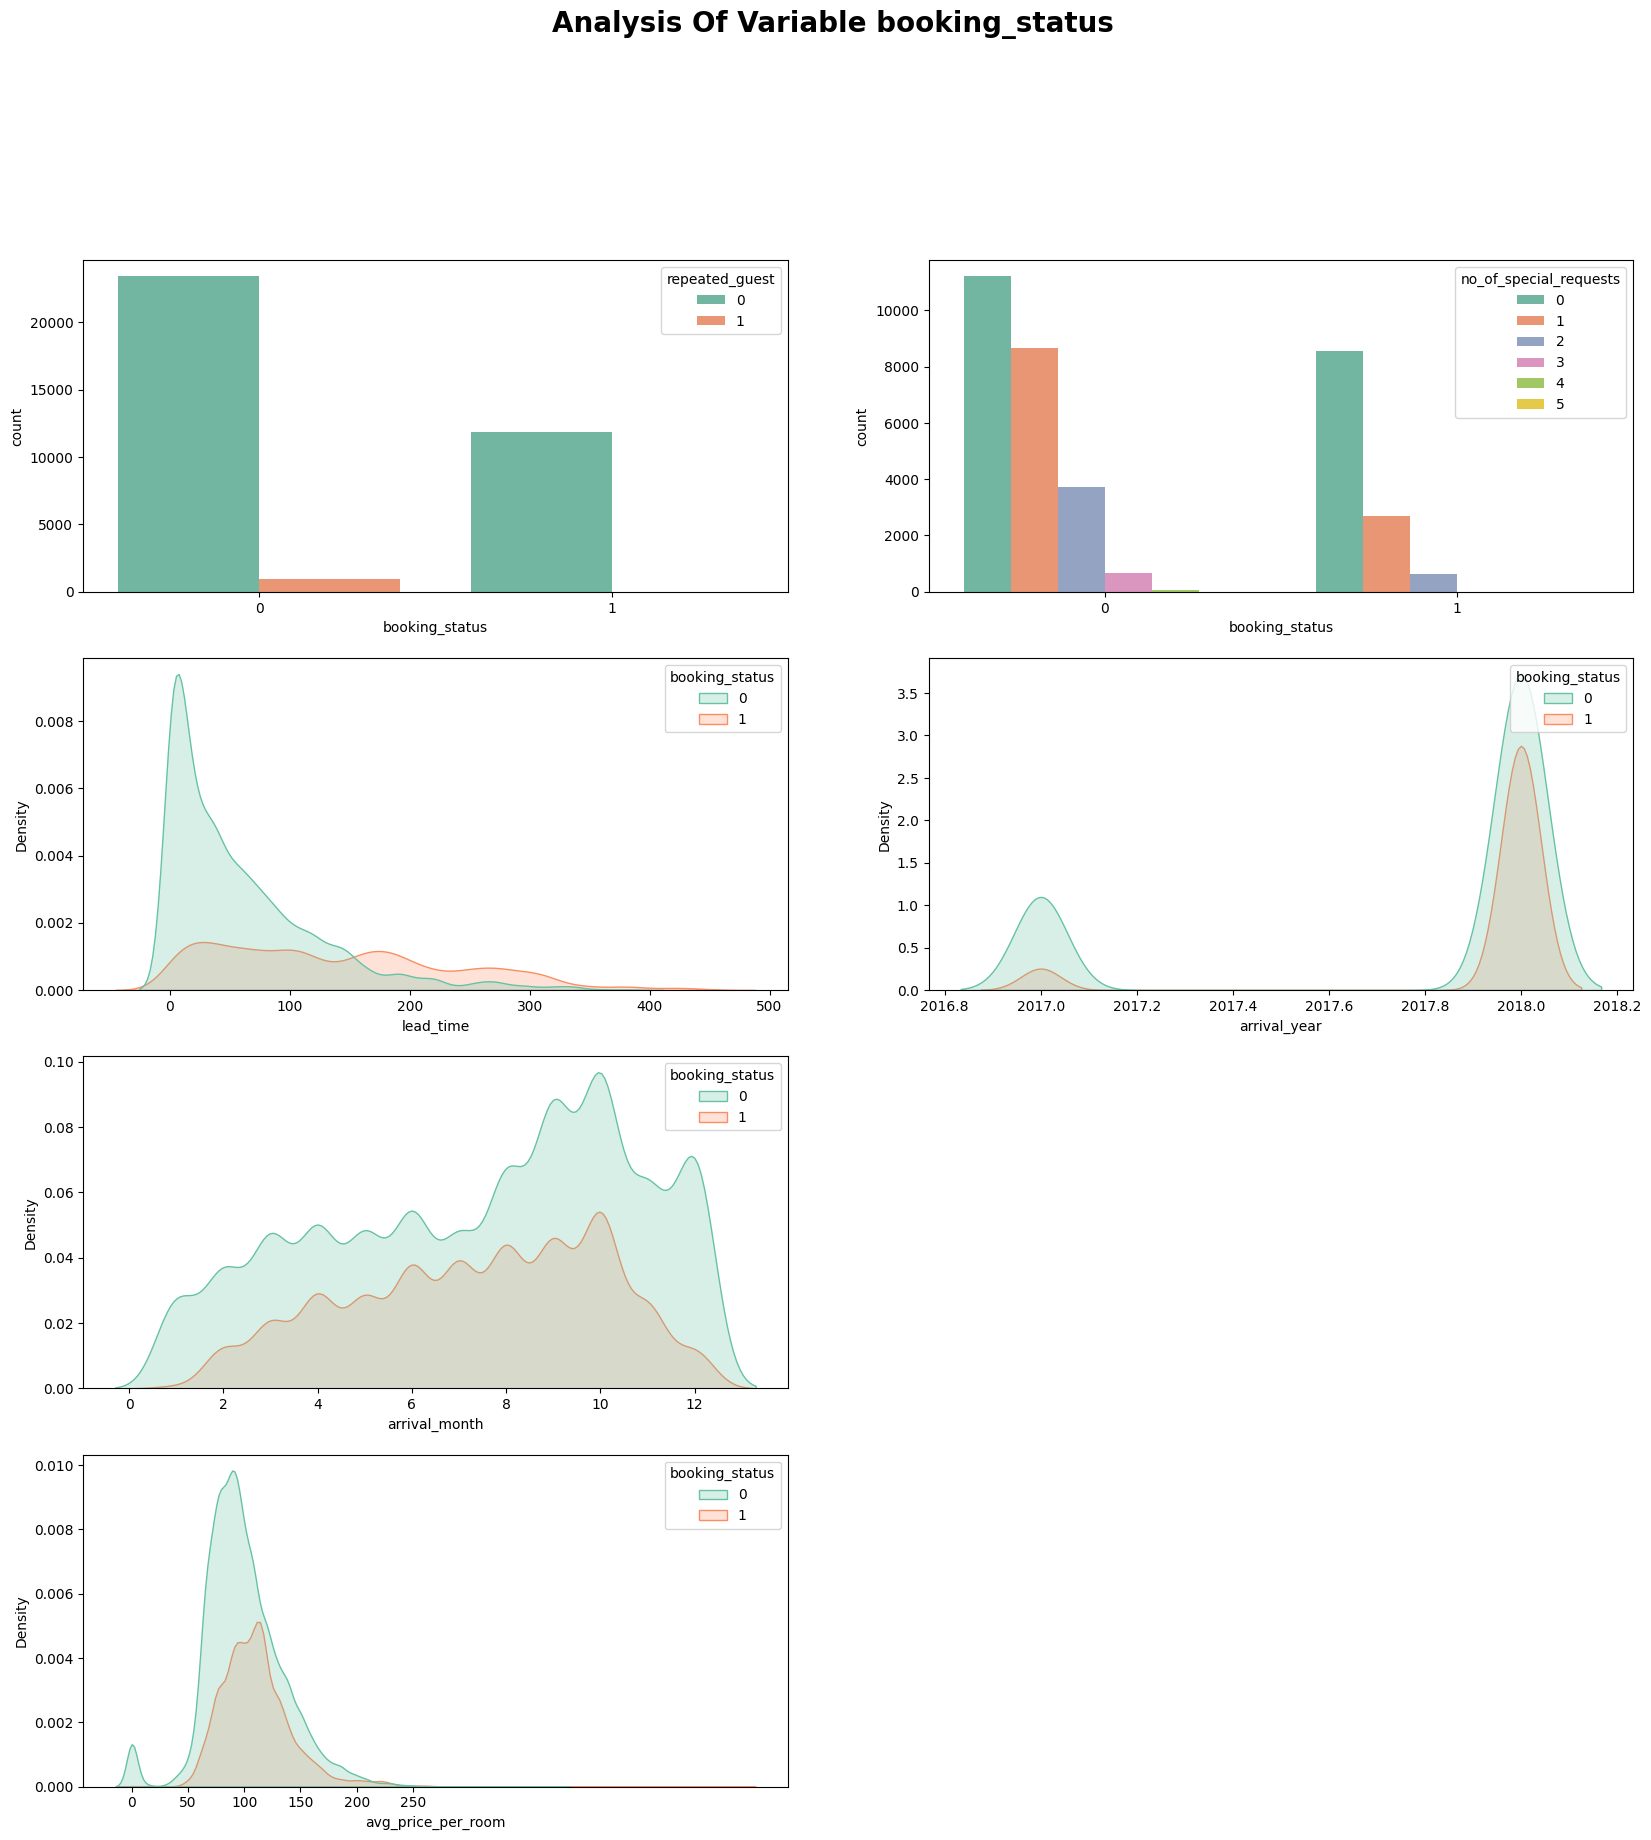

In [33]:
plt.figure(figsize = (20, 25))
plt.suptitle("Analysis Of Variable booking_status",fontweight="bold", fontsize=20)

plt.subplot(5,2,1)
sns.countplot(x = 'booking_status', hue = 'repeated_guest', palette = 'Set2', data = df)

plt.subplot(5,2,2)
sns.countplot(x = 'booking_status', hue = 'no_of_special_requests', palette = 'Set2', data = df)

plt.subplot(5,2,3)
sns.kdeplot(x='lead_time', hue='booking_status', palette = 'Set2', shade=True, data=df)

plt.subplot(5,2,4)
sns.kdeplot(x='arrival_year', hue='booking_status', palette = 'Set2', shade=True, data=df)

plt.subplot(5,2,5)
sns.kdeplot(x='arrival_month', hue='booking_status', palette = 'Set2', shade=True, data=df)

plt.subplot(5,2,7)
sns.kdeplot(x='avg_price_per_room', hue='booking_status', palette = 'Set2', shade=True, data=df).set_xticks(range(0,300,50))

1. average_price_per_room between $120  to  $130 has the highest possibility to cancel
2. lead_time over 150 has more than 50% chance to cancel.
3. 2018 has higher ratio than 2017 to cancel

In [34]:
# How many repeated guest cancelled?
df[(df['repeated_guest']==1) & (df['booking_status']==1)]["no_of_adults"].count()

16

In [35]:
# How many repeated guest didn't cancel?
df[(df['repeated_guest']==1) & (df['booking_status']==0)]["no_of_adults"].count()

914

In [36]:
# How many non-repeated guest cancelled?
df[(df['repeated_guest']==0) & (df['booking_status']==1)]["no_of_adults"].count()

11869

In [37]:
# How many non-repeated guest didn't cancel?
df[(df['repeated_guest']==0) & (df['booking_status']==0)]["no_of_adults"].count()

23476

Repeated guest has significantly smaller cancellation rate.

## lead_time

C:\Users\vickytc\AppData\Local\Temp\ipykernel_18260\1832482653.py:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vickytc\AppData\Local\Temp\ipykernel_18260\1832482653.py:8: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vickytc\AppData\Local\Temp\ipykernel_18260\1832482653.py:11: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vickytc\AppData\Local\Temp\ipykernel_18260\1832482653.py:14: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<Axes: xlabel='lead_time', ylabel='Density'>

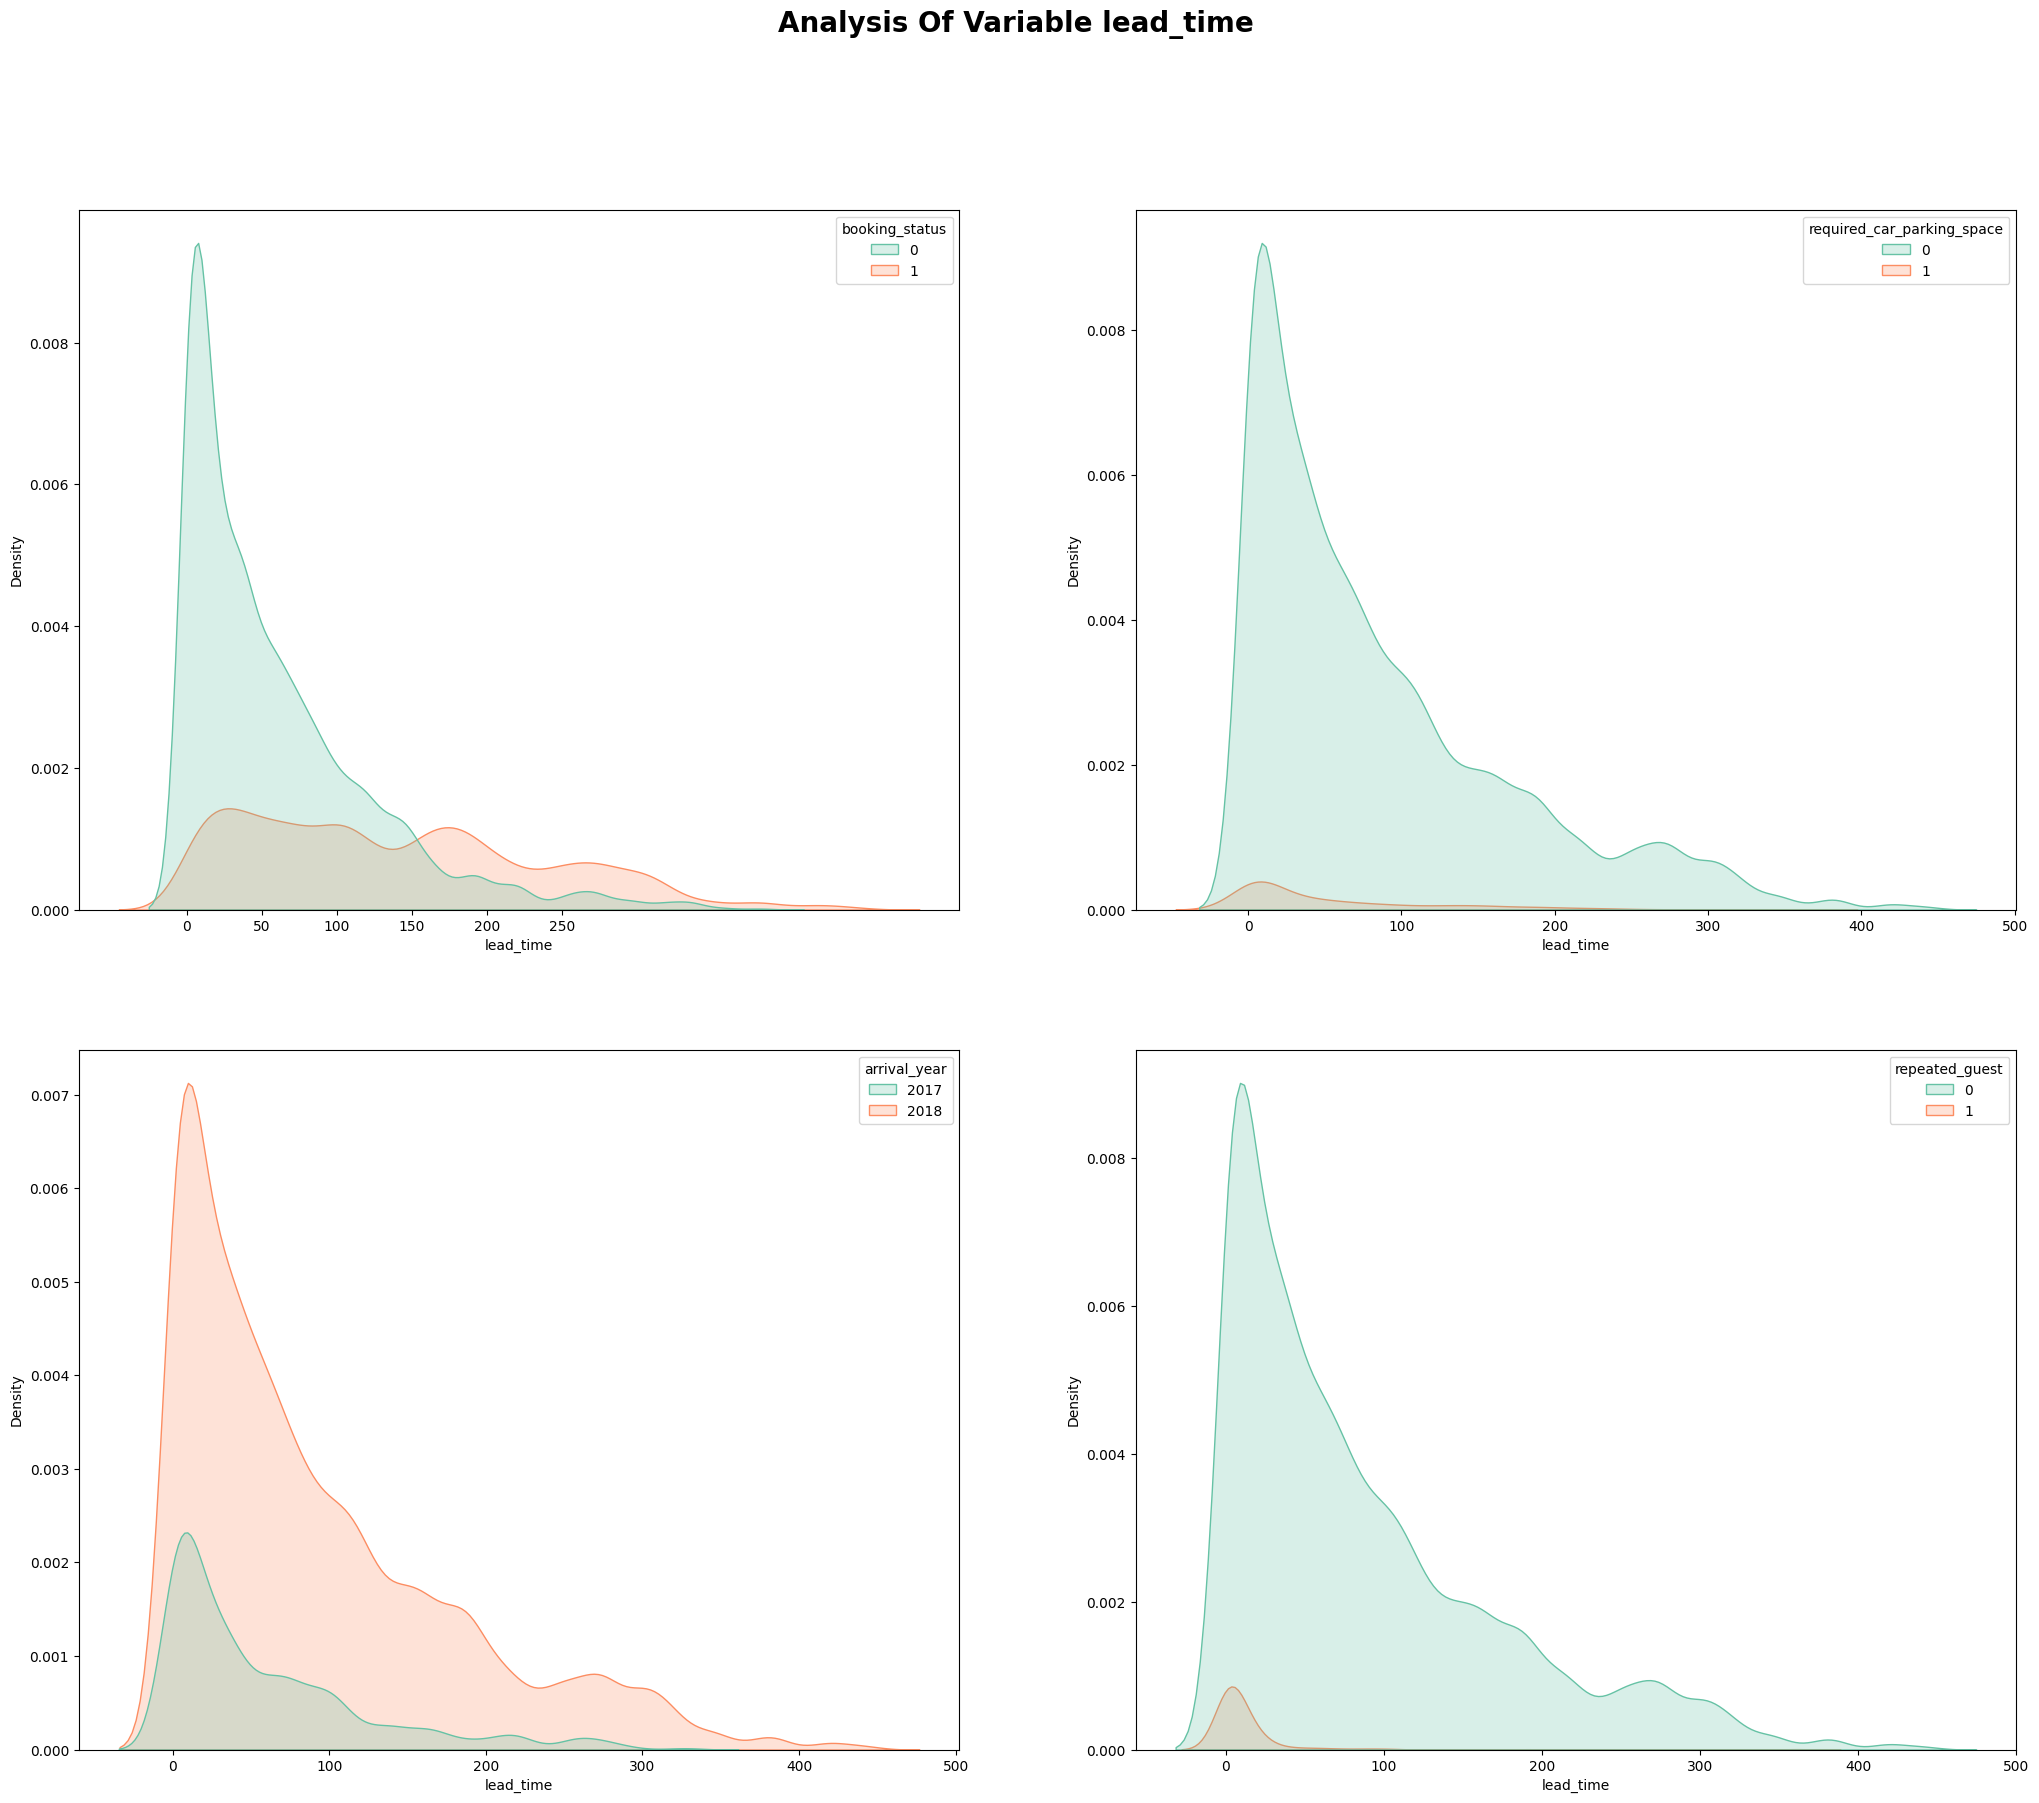

In [38]:
plt.figure(figsize = (25, 20))
plt.suptitle("Analysis Of Variable lead_time",fontweight="bold", fontsize=20)

plt.subplot(2,2,1)
sns.kdeplot(x='lead_time', hue='booking_status', palette = 'Set2', shade=True, data=df).set_xticks(range(0,300,50))

plt.subplot(2,2,2)
sns.kdeplot(x = 'lead_time', hue = 'required_car_parking_space', palette = 'Set2', shade=True, data = df)

plt.subplot(2,2,3)
sns.kdeplot(x = 'lead_time', hue = 'arrival_year', palette = 'Set2', shade=True, data = df)

plt.subplot(2,2,4)
sns.kdeplot(x='lead_time', hue='repeated_guest', palette = 'Set2', shade=True, data=df)

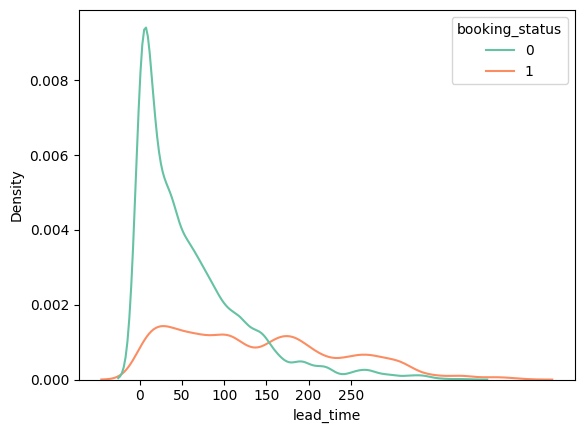

In [39]:
sns.kdeplot(x='lead_time', hue='booking_status', palette = 'Set2', data=df).set_xticks(range(0,300,50))
plt.show()

<Axes: xlabel='lead_time', ylabel='avg_price_per_room'>

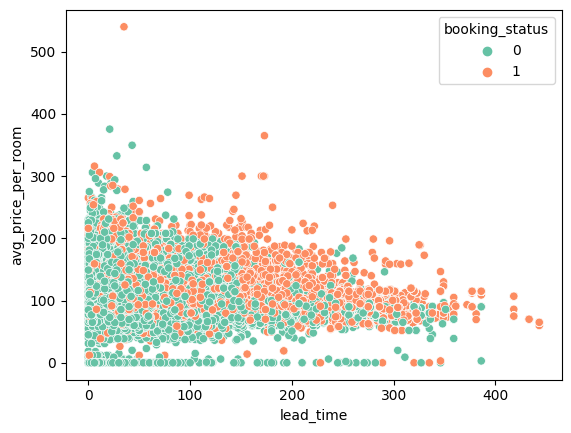

In [40]:
sns.scatterplot(data=df, x="lead_time", y="avg_price_per_room", palette = 'Set2', hue = 'booking_status')

## Log Transformation

In [41]:
# normalizing all numerical variables
num_df = df.copy(deep=True)
num_df = np.log(num_df.iloc[:,:-1]+1) # +1 is because there are some values, 0, in df.
num_df

no_of_adults  no_of_weekend_nights  no_of_week_nights  \
0          1.098612              0.693147           1.098612   
1          1.098612              1.098612           1.386294   
2          0.693147              1.098612           0.693147   
3          1.098612              0.000000           1.098612   
4          1.098612              0.693147           0.693147   
...             ...                   ...                ...   
36270      1.386294              1.098612           1.945910   
36271      1.098612              0.693147           1.386294   
36272      1.098612              1.098612           1.945910   
36273      1.098612              0.000000           1.386294   
36274      1.098612              0.693147           1.098612   

       type_of_meal_plan  required_car_parking_space  room_type_reserved  \
0               0.693147                         0.0            0.693147   
1               0.000000                         0.0            0.693147   
2               0.693147                         0.0            0.693147   
3               0.693147                         0.0            0.693147   
4               0.000000                         0.0            0.693147   
...                  ...                         ...                 ...   
36270           0.693147                         0.0            1.609438   
36271           0.693147                         0.0            0.693147   
36272           0.693147                         0.0            0.693147   
36273           0.000000                         0.0            0.693147   
36274           0.693147                         0.0            0.693147   

       lead_time  arrival_year  arrival_month  market_segment_type  \
0       5.416100      7.609862       2.397895             0.693147   
1       1.791759      7.610358       2.484907             1.098612   
2       0.693147      7.610358       1.098612             1.098612   
3       5.356586      7.610358       1.791759             1.098612   
4       3.891820      7.610358       1.609438             1.098612   
...          ...           ...            ...                  ...   
36270   4.454347      7.610358       2.197225             1.098612   
36271   5.433722      7.610358       2.397895             1.098612   
36272   5.003946      7.610358       2.079442             1.098612   
36273   4.158883      7.610358       1.609438             1.098612   
36274   5.337538      7.610358       2.564949             0.693147   

       repeated_guest  no_of_previous_cancellations  \
0                 0.0                           0.0   
1                 0.0                           0.0   
2                 0.0                           0.0   
3                 0.0                           0.0   
4                 0.0                           0.0   
...               ...                           ...   
36270             0.0                           0.0   
36271             0.0                           0.0   
36272             0.0                           0.0   
36273             0.0                           0.0   
36274             0.0                           0.0   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                       0.0            4.189655   
1                                       0.0            4.679164   
2                                       0.0            4.110874   
3                                       0.0            4.615121   
4                                       0.0            4.559126   
...                                     ...                 ...   
36270                                   0.0            5.128715   
36271                                   0.0            4.521245   
36272                                   0.0            4.599052   
36273                                   0.0            4.559126   
36274                                   0.0            5.091724   

       no_of_speci

# Building the ML

In [42]:
# Feature Selection
X = num_df.copy(deep=True)
# Target
y = df['booking_status']

In [43]:
X.shape, y.shape

((36275, 15), (36275,))

In [44]:
# splitting data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

In [45]:
y_train.value_counts()

0    17114
1     8278
Name: booking_status, dtype: int64

Use oversampling technique to balance the training data

In [72]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training set
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
y_smote.value_counts()

1    17114
0    17114
Name: booking_status, dtype: int64

Accuracy of Logistic Regression is : 0.76
Confusion Matrix : 
[[5468 1808]
 [ 807 2800]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.75      0.81      7276
           1       0.61      0.78      0.68      3607

    accuracy                           0.76     10883
   macro avg       0.74      0.76      0.74     10883
weighted avg       0.78      0.76      0.77     10883



c:\users\vickytc\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



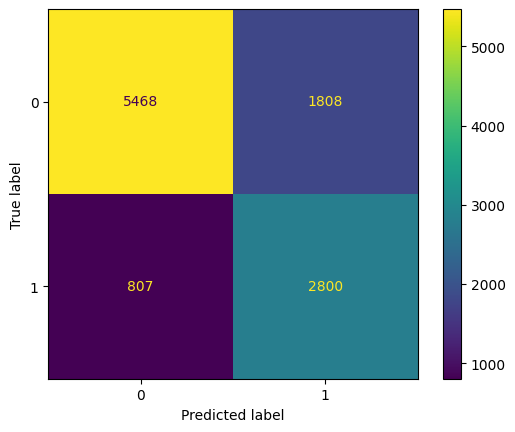

In [74]:
lr = LogisticRegression()
lr.fit(X_smote, y_smote)

y_pred_lr = lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lr)
conf = confusion_matrix(y_test, y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)

print(f"Accuracy of Logistic Regression is : {accuracy:.2f}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

ConfusionMatrixDisplay(confusion_matrix = conf).plot()
plt.show()

## XGBoost 

Accuracy of XGBoost Classifier is : 0.79
Confusion Matrix : 
[[5237 2039]
 [ 256 3351]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      7276
           1       0.62      0.93      0.74      3607

    accuracy                           0.79     10883
   macro avg       0.79      0.82      0.78     10883
weighted avg       0.84      0.79      0.80     10883



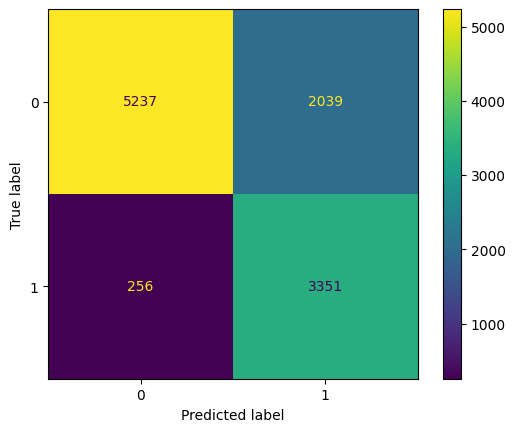

In [94]:
xgbc = xgb.XGBClassifier(booster = 'gbtree')
xgbc.fit(X_smote, y_smote)

y_pred_xgb = xgbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
conf = confusion_matrix(y_test, y_pred_xgb)
clf_report = classification_report(y_test, y_pred_xgb)

print(f"Accuracy of XGBoost Classifier is : {accuracy:.2f}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

ConfusionMatrixDisplay(confusion_matrix = conf).plot()
plt.show()

The baseline model, regression, has only 53% AUC, but XGBoost got 60% AUC.

## XGBoost using DMatrix (the main XGBoost dtype)

XGBoost gets its lauded performance and efficiency gains by utilizing its own optimized data structure for datasets called a DMatrix.

In [93]:
# convert to DMatrix
dtrain = xgb.DMatrix(X_smote, y_smote)
dtest = xgb.DMatrix(X_test, y_test)

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

xgb_clf = xgb.train(params, dtrain)

# make prediction
preds = xgb_clf.predict(dtest) # return [0.04591011 0.9088097  0.02660659 ... 0.14886013 0.05369152 0.6656908 ]

# XGBoost returns the probability for the elements to be true, 
# so we should encode this array to a binary one:
threshold = 0.5
preds = [1 if i > threshold else 0 for i in preds]

# print accuracy score
print(f"Accuracy of XGBoost Classifier is : {np.round(accuracy_score(y_test, preds)*100, 2)}%")
clf_report = classification_report(y_test, preds)
print(f"Classification Report : \n{clf_report}")

Accuracy of XGBoost Classifier is : 77.74%
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      7276
           1       0.62      0.87      0.72      3607

    accuracy                           0.78     10883
   macro avg       0.77      0.80      0.77     10883
weighted avg       0.82      0.78      0.78     10883



## Try the Feature Generation and Feature Selection on XGBoost using Dmatrix

Feature importance can be defined as a type of classification for each feature on how much can that feature contribute for the predictions. That can be done in many ways, but one that is used here is lightgbm, that is a model based on desicion tree and every type of model based on that, such as random forest, xgboost, gradient boost and etc can return this information.


The correlation matrix is calculated using Pearson's, and it tells us how much the features are related to each other. When they are positive, they move in the same direction, and when they are negative, they move in the opposite direction. Features that are closer to 1  or -1 are more related, and those that are closer to 0 have no correlation at all. This information can be used to create some features in feature generation, where we can look to match features with a certain degree of correlation; in this case, just one correlation was used to create a new feature. which lead_time (one of the most important features) has a considerable degree of correlation with the number of week nights.

In [77]:
# Feature Generation
num_df['fg1'] = num_df[['lead_time','market_segment_type']].apply(lambda x: (x[0]*x[1]),axis=1)
num_df['fg1'] = np.log(num_df['fg1']+1) # +1 is because there are some values, 0, in df.

# Feature Selection
X = num_df.copy(deep=True)

# Target
y = df['booking_status']

c:\users\vickytc\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Accuracy of XGBoost Classifier is : 77.39%
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      7276
           1       0.61      0.88      0.72      3607

    accuracy                           0.77     10883
   macro avg       0.77      0.80      0.77     10883
weighted avg       0.82      0.77      0.78     10883

Confusion Matrix : 
[[5245 2031]
 [ 430 3177]]


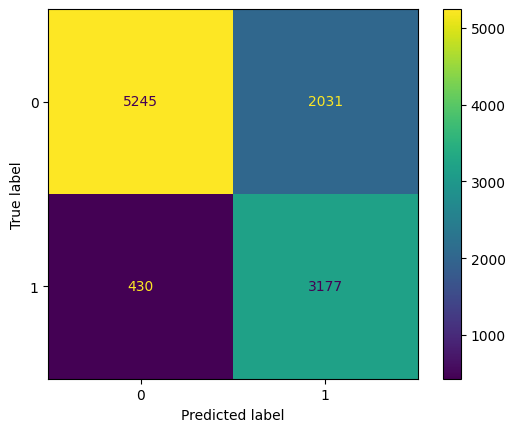

In [78]:
# splitting data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

undersampler = ClusterCentroids()
X_smote, y_smote = undersampler.fit_resample(X_train, y_train)


# convert to DMatrix
dtrain = xgb.DMatrix(X_smote, y_smote)
dtest = xgb.DMatrix(X_test, y_test)

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

xgb_clf = xgb.train(params, dtrain)

# make prediction
preds = xgb_clf.predict(dtest) # return [0.04591011 0.9088097  0.02660659 ... 0.14886013 0.05369152 0.6656908 ]

# XGBoost returns the probability for the elements to be true, 
# so we should encode this array to a binary one:
threshold = 0.5
preds = [1 if i > threshold else 0 for i in preds]

# print accuracy score
print(f"Accuracy of XGBoost Classifier is : {np.round(accuracy_score(y_test, preds)*100, 2)}%")
clf_report = classification_report(y_test, preds)
print(f"Classification Report : \n{clf_report}")
conf = confusion_matrix(y_test, preds)
print(f"Confusion Matrix : \n{conf}")

ConfusionMatrixDisplay(confusion_matrix = conf).plot()
plt.show()

PR AUC wasn't raised after doing the further feature generation and feature selection.

In [79]:
# Feature Selection: not include 'fg1'
X = num_df.loc[:, num_df.columns != 'fg1'] 

# Target
y = df['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

X_smote, y_smote = undersampler.fit_resample(X_train, y_train)

c:\users\vickytc\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## Use xgboost.DMatrix and Bayesian Optimization for Parameter tuning Optimization

In [80]:
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (60, 500),
    'max_depth': (2, 20),
    'gamma': (0, 5)}

# objective function
def xgboost_hyper_param(learning_rate, n_estimators, max_depth, gamma):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    xgbc = xgb.XGBClassifier( max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma, objective = 'binary:logistic')
    return np.mean(cross_val_score(xgbc, X, y, cv=10, scoring='accuracy')) 

In [81]:
optimizer = BayesianOptimization( f=xgboost_hyper_param, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=3, n_iter=24, acq='ei', xi=0.01)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------


C:\Users\vickytc\AppData\Local\Temp\ipykernel_18260\3857726614.py:2: DeprecationWarning:


Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument




| 1         | 0.8897    | 1.873     | 0.9512    | 15.18     | 323.4     |
| 2         | 0.8754    | 0.7801    | 0.1644    | 3.046     | 441.1     |
| 3         | 0.8616    | 3.006     | 0.711     | 2.371     | 486.8     |
| 4         | 0.8978    | 0.5993    | 0.4766    | 14.03     | 342.2     |
| 5         | 0.8874    | 5.0       | 1.0       | 20.0      | 381.0     |
| 6         | 0.8979    | 0.7719    | 0.2996    | 14.32     | 341.0     |
| 7         | 0.8758    | 4.891     | 0.1173    | 6.994     | 60.06     |
| 8         | 0.8973    | 3.259     | 0.1554    | 19.86     | 187.5     |
| 9         | 0.8542    | 3.439     | 0.2493    | 2.175     | 226.4     |
| 10        | 0.8971    | 2.613     | 0.1414    | 20.0      | 155.2     |
| 11        | 0.7712    | 0.0       | 0.01      | 2.0       | 120.8     |
| 12        | 0.8939    | 0.0       | 0.9508    | 20.0      | 279.2     |
| 13        | 0.8584    | 5.0       | 1.0       | 2.0       | 173.1     |
| 14        | 0.7982    | 5.0       | 

In [82]:
# the best params:
optimizer.max["params"]

{'gamma': 0.3807100686149978,
 'learning_rate': 0.2532404479820429,
 'max_depth': 19.935740490017775,
 'n_estimators': 76.13476891740402}

In [83]:
# We create the XGboost-specific DMatrix data format from the numpy array. 
# This data structure is optimised for memory efficiency and training speed
dtrain = xgb.DMatrix(X_smote, label=y_smote)
dvalid = xgb.DMatrix(X_test, label=y_test)

[05:20:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample", "n_estimators" } are not used.

Accuracy of XGBoost Classifier is : 81.42%
Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      7276
           1       0.68      0.84      0.75      3607

    accuracy                           0.81     10883
   macro avg       0.79      0.82      0.80     10883
weighted avg       0.83      0.81      0.82     10883

Confusion Matrix : 
[[5828 1448]
 [ 574 3033]]


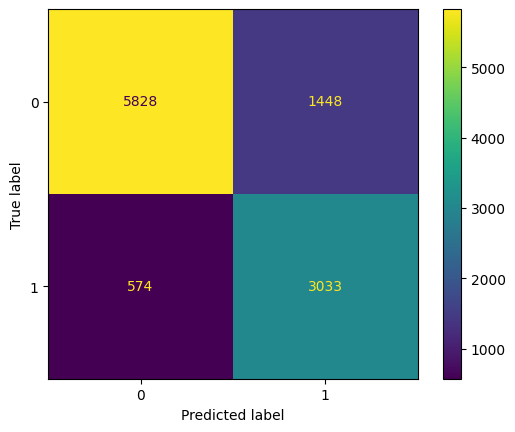

In [92]:
{'gamma': 0.3807100686149978,
 'learning_rate': 0.2532404479820429,
 'max_depth': 19.935740490017775,
 'n_estimators': 76.13476891740402}

params["max_depth"] = int(params["max_depth"])
params["n_estimators"] = int(params["n_estimators"])
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"

# build the model
xgb_clf = xgb.train(params, dtrain)

# make prediction
preds = xgb_clf.predict(dvalid) # return [0.04591011 0.9088097  0.02660659 ... 0.14886013 0.05369152 0.6656908 ]

# XGBoost returns the probability for the elements to be true, 
# so we should encode this array to a binary one:
threshold = 0.5
preds = [1 if i > threshold else 0 for i in preds]

# print accuracy score
print(f"Accuracy of XGBoost Classifier is : {np.round(accuracy_score(y_test, preds)*100, 2)}%")
clf_report = classification_report(y_test, preds)
print(f"Classification Report : \n{clf_report}")
conf = confusion_matrix(y_test, preds)
print(f"Confusion Matrix : \n{conf}")

ConfusionMatrixDisplay(confusion_matrix = conf).plot()
plt.show()

# PCA + Train XGBoost classifier + Tune hyperparameters using BO

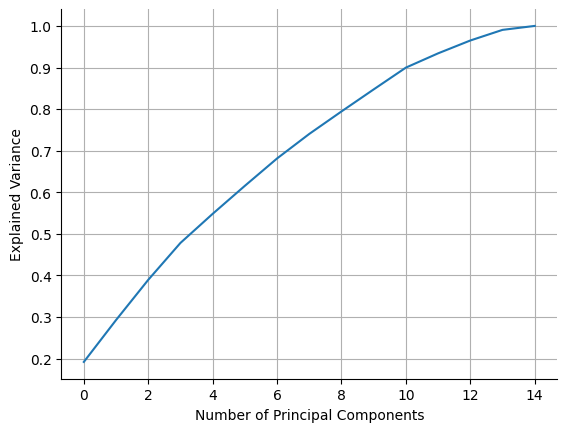

In [96]:
# transform correlated variables into a smaller number of uncorrelated variables.
# This is done by projecting the original data into the reduced PCA space 
# using the eigenvectors of the covariance/correlation matrix aka the principal components (PCs).

# The PCA model
# Before we perform PCA, we need to normalise the features so that they have zero mean and unit variance
scaler = StandardScaler()
train_x_norm = scaler.fit_transform(X_smote)

pca = PCA()
comp = pca.fit(train_x_norm)

# We plot a graph to show how the explained variation in the features varies with the number of principal components
plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine(); # take away the top and right spines


The first 8 principal components explains about 80% of the variation.

The first 13 principal components explains about 95% of the variation

In [97]:
# Using the first 13 principal components, we apply the PCA mapping
# From here on, we work with 13 features instead of the full set of 15 features
pca = PCA(n_components=13).fit(train_x_norm)
train_x_transform = pca.transform(train_x_norm)

In [98]:
# Transform the validation set
valid_x_transform = pca.transform(scaler.transform(X_test))

In [99]:
# We create the XGboost-specific DMatrix data format from the numpy array. 
# This data structure is optimised for memory efficiency and training speed
dtrain = xgb.DMatrix(train_x_transform, label=y_smote)
dvalid = xgb.DMatrix(valid_x_transform, label=y_test)

[05:23:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Accuracy of XGBoost Classifier is : 82.32%
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7276
           1       0.69      0.85      0.76      3607

    accuracy                           0.82     10883
   macro avg       0.80      0.83      0.81     10883
weighted avg       0.84      0.82      0.83     10883

Confusion Matrix : 
[[5895 1381]
 [ 543 3064]]


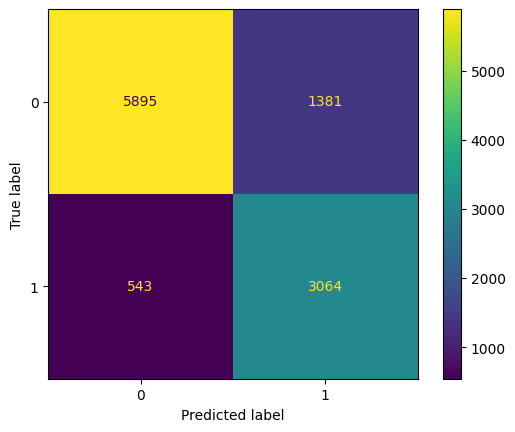

In [101]:
{'gamma': 0.3807100686149978,
 'learning_rate': 0.2532404479820429,
 'max_depth': 19.935740490017775,
 'n_estimators': 76.13476891740402}

params["max_depth"] = int(params["max_depth"])
params["n_estimators"] = int(params["n_estimators"])
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"

# build the model
xgb_clf = xgb.train(params, dtrain)

# make prediction
preds = xgb_clf.predict(dvalid) # return [0.04591011 0.9088097  0.02660659 ... 0.14886013 0.05369152 0.6656908 ]

# XGBoost returns the probability for the elements to be true, 
# so we should encode this array to a binary one:
threshold = 0.5
preds = [1 if i > threshold else 0 for i in preds]

# print accuracy score
print(f"Accuracy of XGBoost Classifier is : {np.round(accuracy_score(y_test, preds)*100, 2)}%")
clf_report = classification_report(y_test, preds)
print(f"Classification Report : \n{clf_report}")
conf = confusion_matrix(y_test, preds)
print(f"Confusion Matrix : \n{conf}")

ConfusionMatrixDisplay(confusion_matrix = conf).plot()
plt.show()

# PCA + Train XGBoost classifier + Tune hyperparameters using Grid Search

[05:14:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample", "n_estimators" } are not used.

Accuracy of XGBoost Classifier is : 81.42%
Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      7276
           1       0.68      0.84      0.75      3607

    accuracy                           0.81     10883
   macro avg       0.79      0.82      0.80     10883
weighted avg       0.83      0.81      0.82     10883

Confusion Matrix : 
[[5828 1448]
 [ 574 3033]]


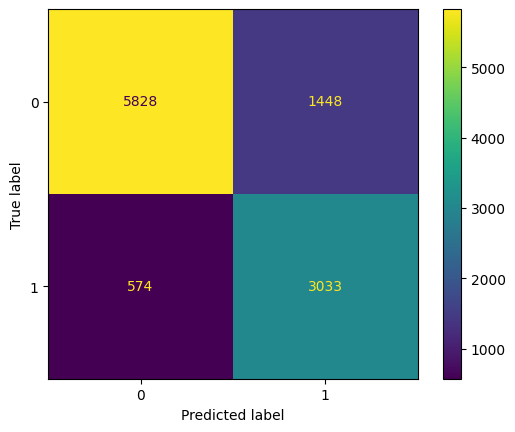

In [90]:
params = {'colsample': 1.0,
 'eta': 0.1,
 'gamma': 5,
 'max_depth': 20,
 'n_estimators': 500,
 'subsample': 1.0}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"

# build the model
xgb_clf = xgb.train(params, dtrain)

# make prediction
preds = xgb_clf.predict(dvalid) # return [0.04591011 0.9088097  0.02660659 ... 0.14886013 0.05369152 0.6656908 ]

# XGBoost returns the probability for the elements to be true, 
# so we should encode this array to a binary one:
threshold = 0.5
preds = [1 if i > threshold else 0 for i in preds]

# print accuracy score
print(f"Accuracy of XGBoost Classifier is : {np.round(accuracy_score(y_test, preds)*100, 2)}%")
clf_report = classification_report(y_test, preds)
print(f"Classification Report : \n{clf_report}")
conf = confusion_matrix(y_test, preds)
print(f"Confusion Matrix : \n{conf}")

ConfusionMatrixDisplay(confusion_matrix = conf).plot()
plt.show()

# XAI - SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


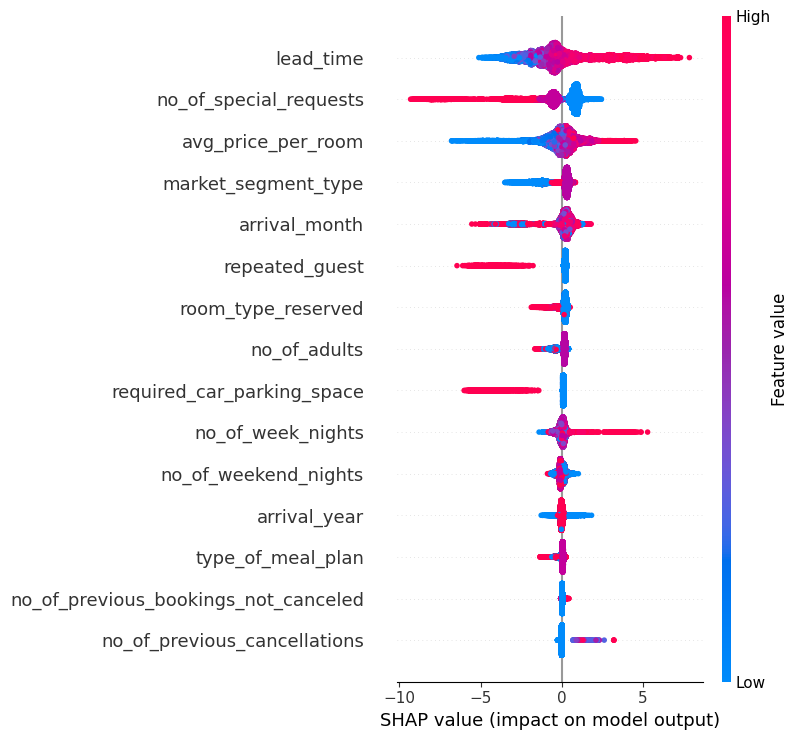

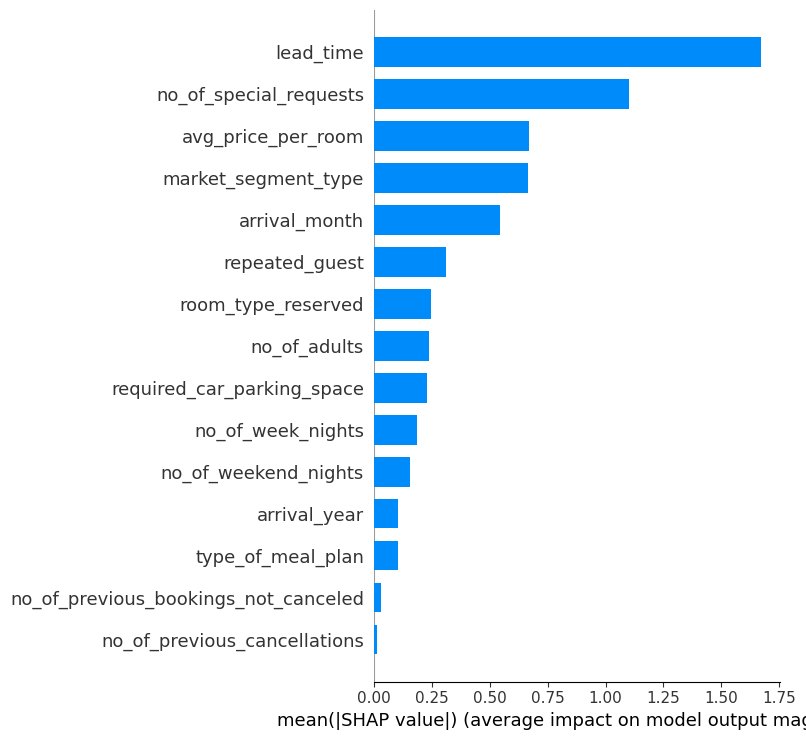

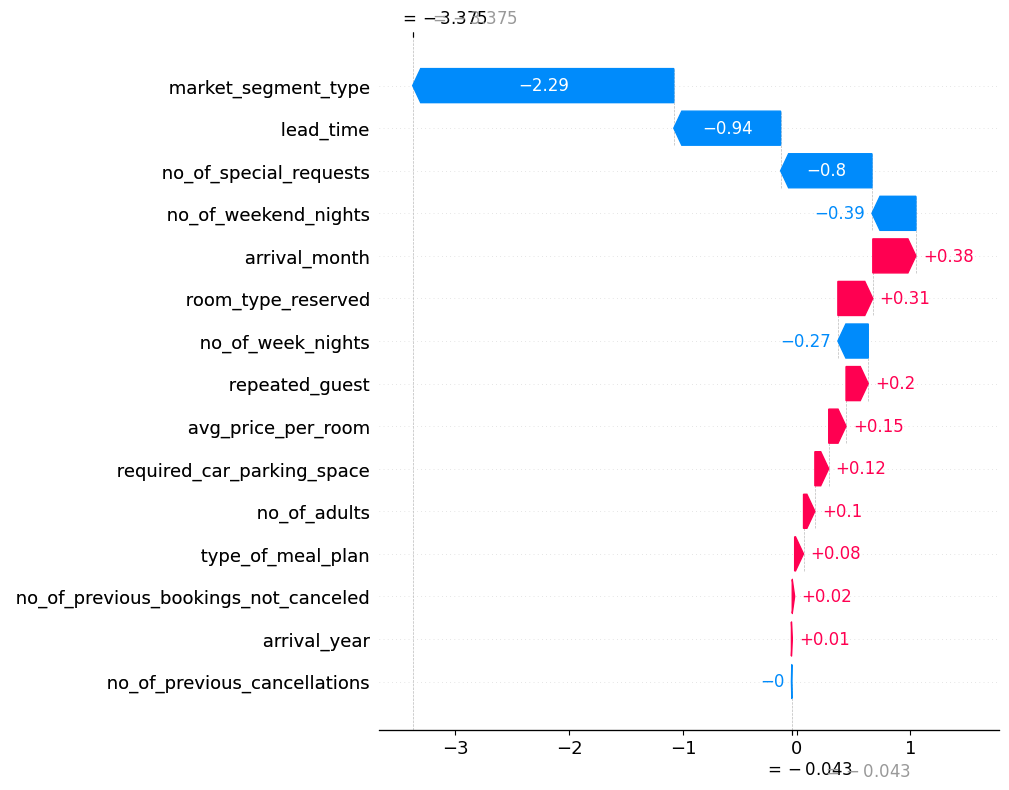

In [102]:
import shap

# Generate the Tree explainer and SHAP values
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

############## visualizations #############
# Generate summary dot plot
shap.summary_plot(shap_values, X,title="SHAP summary plot") 

# Generate summary bar plot 
shap.summary_plot(shap_values, X,plot_type="bar") 

# Generate waterfall plot  
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[79], features=X.loc[79,:], feature_names=X.columns, max_display=15, show=True)

